<a href="https://colab.research.google.com/github/gorzanskik-ai/statistics/blob/main/02_probits/06_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/statistics/data/yellow_tripdata_2021-05.parquet"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
taxi = pd.read_parquet(path, engine='auto',
        columns=['trip_distance', 'tpep_pickup_datetime', "tip_amount", "fare_amount","RatecodeID"],
        storage_options=None, use_nullable_dtypes=False)

taxi.query("tpep_pickup_datetime>='2021-05-09' and tpep_pickup_datetime<'2021-05-10'",
    inplace=True)

taxi.query("tip_amount<=100 and fare_amount>0 and RatecodeID==4 and tip_amount>0", inplace=True)

In [25]:
fare_amount_mean = taxi['fare_amount'].mean()
fare_amount_std = taxi['fare_amount'].std()

tip_amount_mean = taxi['tip_amount'].mean()
tip_amount_std = taxi['tip_amount'].std()

fare_amount_low = fare_amount_mean - 3 * fare_amount_std
fare_amount_high = fare_amount_mean + 3 * fare_amount_std

tip_amount_low = tip_amount_mean - 3 * tip_amount_std
tip_amount_high = tip_amount_mean + 3 * tip_amount_std

In [26]:
outliers = taxi.query(f'(fare_amount < {fare_amount_low} or fare_amount > {fare_amount_high}) or (tip_amount > {tip_amount_high} or tip_amount < {tip_amount_low})')
taxi.query(f'(fare_amount <= {fare_amount_high} and fare_amount >= {fare_amount_low}) and (tip_amount <= {tip_amount_high} and tip_amount >= {tip_amount_low})', inplace=True)

In [27]:
outliers

,trip_distance,tpep_pickup_datetime,tip_amount,fare_amount,RatecodeID
638727,67.40,2021-05-09 14:41:58,65.9,327.5,4.0
651141,66.58,2021-05-09 17:53:42,0.1,270.5,4.0


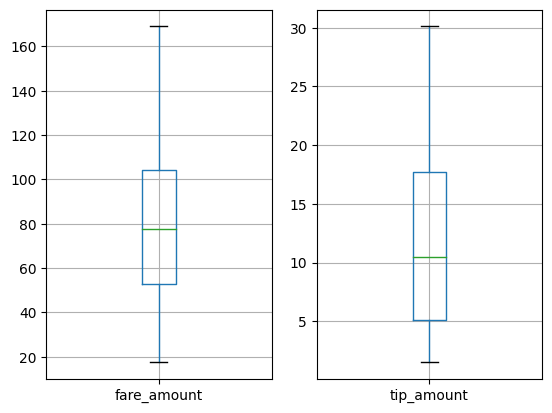

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2)
taxi.boxplot('fare_amount', ax=axes[0], meanline=True)
taxi.boxplot('tip_amount', ax=axes[1], meanline=True)
plt.show()

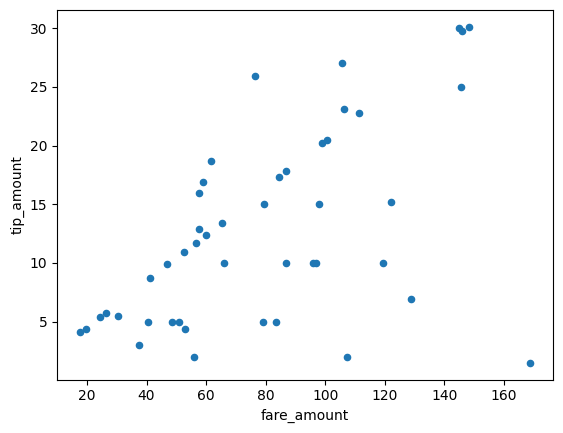

In [29]:
taxi.plot.scatter(x='fare_amount', y='tip_amount')
plt.show()

RANSAC

In [30]:
taxi = pd.read_parquet(path, engine='auto',
        columns=['trip_distance', 'tpep_pickup_datetime', "tip_amount", "fare_amount","RatecodeID"],
        storage_options=None, use_nullable_dtypes=False)

taxi.query("tpep_pickup_datetime>='2021-05-09' and tpep_pickup_datetime<'2021-05-10'",
    inplace=True)

taxi.query("tip_amount<=100 and fare_amount>0 and RatecodeID==4 and tip_amount>0", inplace=True)

In [32]:
from sklearn.linear_model import RANSACRegressor, LinearRegression

In [34]:
ransac = RANSACRegressor(estimator=LinearRegression(), max_trials=100, loss='squared_error', random_state=42, residual_threshold=10)

In [35]:
ransac.fit(taxi['fare_amount'].to_numpy().reshape(-1, 1), taxi['tip_amount'].to_numpy().reshape(-1, 1))

RANSACRegressor(estimator=LinearRegression(), loss='squared_error',
                random_state=42, residual_threshold=10)

In [36]:
inliers_mask = ransac.inlier_mask_  #true gdy inlier false gdy outlier
outlier_mask = np.logical_not(inliers_mask)

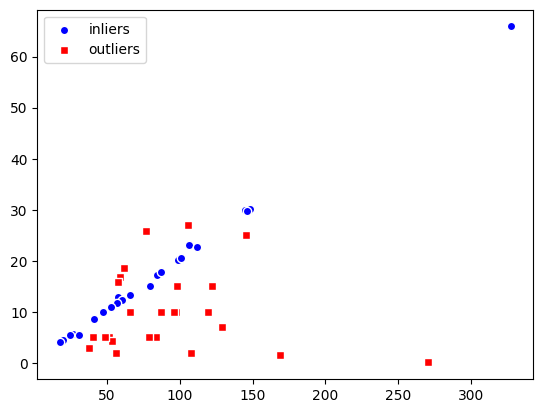

In [38]:
plt.scatter(taxi['fare_amount'][inliers_mask], taxi['tip_amount'][inliers_mask],
            c='blue', edgecolor='white', marker='o', label='Inliers')

plt.scatter(taxi['fare_amount'][outlier_mask], taxi['tip_amount'][outlier_mask],
             c='red', edgecolor='white', marker='s', label='Outliers')
plt.legend(['inliers', 'outliers'])
plt.show()